In [1]:
pip install tensorflow opencv-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


dữ liệu từ WIDER FACE

In [73]:
# import os
# import urllib.request
# import zipfile

# # Tạo thư mục để lưu trữ dữ liệu
# os.makedirs('WIDER_FACE', exist_ok=True)

# # URL của bộ dữ liệu WIDER FACE
# train_path = r"WIDER_FACE\WIDER_train.zip"
# val_path = r"WIDER_FACE\WIDER_val.zip"
# test_path = r"WIDER_FACE\WIDER_test.zip"

# # Tải và giải nén dữ liệu
# def extract_zip(file_path, dest_folder):
#     with zipfile.ZipFile(file_path, 'r') as zip_ref:
#         zip_ref.extractall(dest_folder)

# extract_zip(train_path, 'WIDER_FACE')
# extract_zip(val_path, 'WIDER_FACE')
# extract_zip(test_path, 'WIDER_FACE')

train


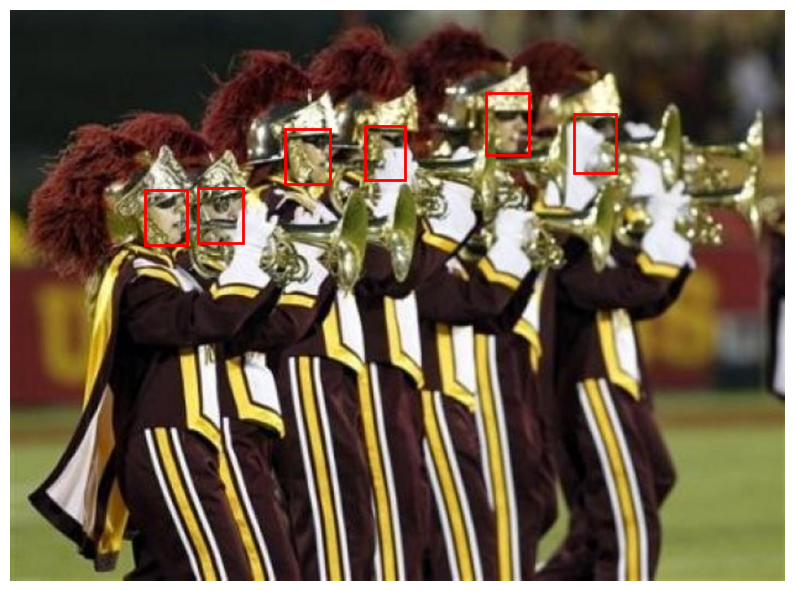

test


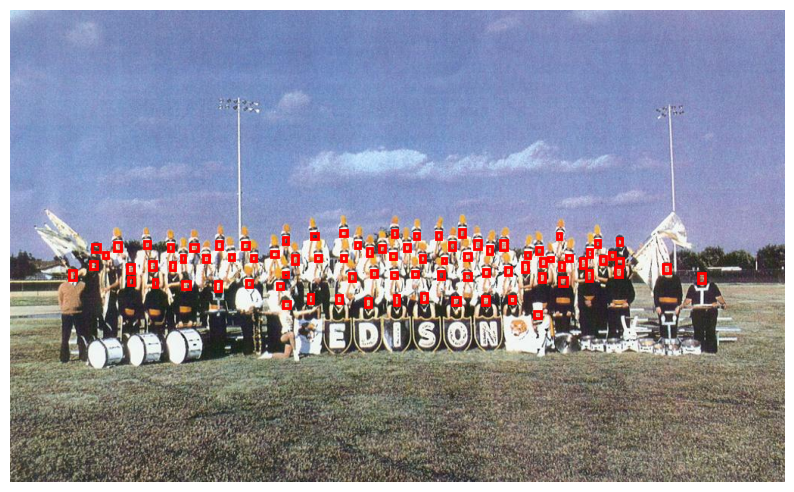

In [20]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

train_img_folder = r'WIDER_FACE/WIDER_train/images'
train_annotation_path = r'wider_face_split/wider_face_train_bbx_gt.txt'

val_img_folder = r'WIDER_FACE\WIDER_val\images'
val_annotation_path = r'wider_face_split\wider_face_val_bbx_gt.txt'

def parse_annotations(annotation_path):
    annotations = {}
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            img_path = lines[i].strip()
            i += 1
            
            if i >= len(lines):
                break
            
            try:
                num_boxes = int(lines[i].strip())
                i += 1
            except ValueError:
                i += 1
                continue
            
            boxes = []
            for _ in range(num_boxes):
                if i >= len(lines):
                    break
                try:
                    box_info = list(map(int, lines[i].strip().split()))
                    x, y, width, height = box_info[:4]
                    boxes.append((x, y, width, height))
                    i += 1
                except ValueError:
                    i += 1
                    continue
            annotations[img_path] = boxes
    return annotations

def visualize_image_with_boxes(img_path, boxes):
    image = Image.open(img_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    for (x, y, width, height) in boxes:
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

print("train")
# Parse annotations
annotations_train = parse_annotations(train_annotation_path)

# Get first image path and its bounding boxes
first_img_path = list(annotations_train.keys())[10]
full_img_path = os.path.join(train_img_folder, first_img_path)
bounding_boxes = annotations_train[first_img_path]

# Visualize the first image with bounding boxes
visualize_image_with_boxes(full_img_path, bounding_boxes)

print("test")
annotations_val = parse_annotations(val_annotation_path)

# Get first image path and its bounding boxes
first_img_path = list(annotations_val.keys())[10]
full_img_path = os.path.join(val_img_folder, first_img_path)
bounding_boxes = annotations_val[first_img_path]

# Visualize the first image with bounding boxes
visualize_image_with_boxes(full_img_path, bounding_boxes)


In [37]:
import tensorflow as tf

In [21]:
# Define the batch size (set to the value you are using, e.g., 32)
batch_size = 32

# Parse the annotations file to get the number of input images
train_annotation_path = r'wider_face_split\wider_face_train_bbx_gt.txt'

def parse_annotations_count(annotation_path):
    count = 0
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            img_path = lines[i].strip()
            i += 1
            
            if i >= len(lines):
                break
            
            try:
                num_boxes = int(lines[i].strip())
                i += 1
            except ValueError:
                i += 1
                continue
            
            for _ in range(num_boxes):
                if i >= len(lines):
                    break
                try:
                    _ = list(map(int, lines[i].strip().split()))
                    i += 1
                except ValueError:
                    i += 1
                    continue
            count += 1
    return count

# Count the number of input images
num_input_images = parse_annotations_count(train_annotation_path)
num_input_images2 = parse_annotations_count(val_annotation_path)
print(f"Số lượng ảnh đầu vào: {num_input_images}, {num_input_images2}")

# Count the number of processed images based on batch size
num_processed_images = (num_input_images // batch_size) * batch_size
num_processed_images2 = (num_input_images2 // batch_size) * batch_size
print(f"Số lượng ảnh đã được xử lý: {num_processed_images},{num_processed_images2}")


Số lượng ảnh đầu vào: 12876, 3226
Số lượng ảnh đã được xử lý: 12864,3200


In [26]:
from PIL import Image

# Đường dẫn đến file ảnh
img_path = r'WIDER_FACE\WIDER_train\images\0--Parade\0_Parade_marchingband_1_116.jpg'

# Mở ảnh bằng Pillow
image = Image.open(img_path)

# Lấy kích thước của ảnh
image_width, image_height = image.size

print(f"Width: {image_width}, Height: {image_height}")


Width: 1024, Height: 680


training 

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [34]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:
import cv2

def preprocess_image(image):
    image = cv2.resize(image, (416, 416))
    image = image / 255.0
    return image

def postprocess_predictions(predictions):
    # Hàm này cần được tùy chỉnh để xử lý kết quả dự đoán
    boxes = []
    confidences = []
    return boxes, confidences

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Tiền xử lý ảnh
    image = preprocess_image(frame)
    image = np.expand_dims(image, axis=0)

    # Dự đoán với mô hình
    predictions = yolo_model.predict(image)
    boxes, confidences = postprocess_predictions(predictions)

    # Vẽ bounding boxes lên khung hình
    for box, confidence in zip(boxes, confidences):
        x, y, w, h = box
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f'{confidence:.2f}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
    
    # Hiển thị khung hình
    cv2.imshow('Face Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
